## Hough Transform for Line Detection

Here we demonstrate an implementation of the Hough Transform for detecting lines in images.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Generating Random Points

We generate a set of random points in the first quadrant.
These points will be used as input data for the Hough Transform demo.


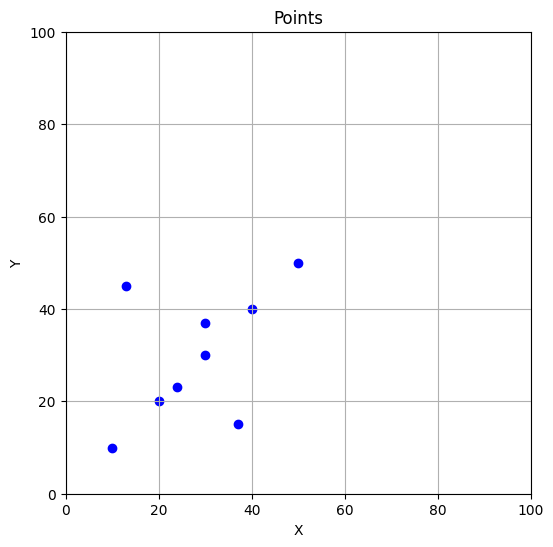

In [3]:
num_points = 20  # Number of points
x_max = 100      # max x value
y_max = 100      # max y value

# # np.random.seed(37317)
# x_points = np.random.uniform(0, x_max, num_points)
# y_points = np.random.uniform(0, y_max, num_points)
x_points = [10,20,30,40,50,24,13,37,30]
y_points = [10,20,30,40,50,23,45,15,37]

plt.figure(figsize=(6, 6))
plt.scatter(x_points, y_points, color='blue')
plt.xlim(0, x_max)
plt.ylim(0, y_max)
plt.title('Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


## Hough Transform Implementation

We apply the Hough Transform to the generated points to detect lines as intersections in the parameter space.


In [4]:
def hough_line_points(x_points, y_points, angle_step=1, rho_step=1):
    # ranges for Rho and Theta
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    diag_len = int(np.ceil(np.sqrt(x_max**2 + y_max**2)))
    rhos = np.arange(-diag_len, diag_len + rho_step, rho_step)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    num_rhos = len(rhos)

    # Accumulator matrix
    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.int64)

    # Votes for the accumulator
    for i in range(len(x_points)):
        x = x_points[i]
        y = y_points[i]
        for t_idx in range(num_thetas): # More efficient, we don't really need to go through all A[] entries,
            single_rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))# for a given, angle, we vote in a single theta,tho position.
            rho_idx = int((single_rho + diag_len) / rho_step)  # Adjust rho_idx based on rho_step
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, t_idx] += 1

    return accumulator, thetas, rhos


## Visualizing the Hough Transform

Visualization of the accumulator matrix to show the parameter space that correspond to lines.


In [5]:
def plot_hough_accumulator(accumulator, thetas, rhos):
    plt.figure(figsize=(10, 10))
    plt.imshow(
        accumulator, cmap='hot', 
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]]
    )
    plt.title('Hough Transform Accumulator')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Rho (pixels)')
    plt.grid(True)
    plt.colorbar()
    plt.show()

## Apply Hough Transform and Visualize Results

Now we use the Hough Transform on the random set of points and visualize it.


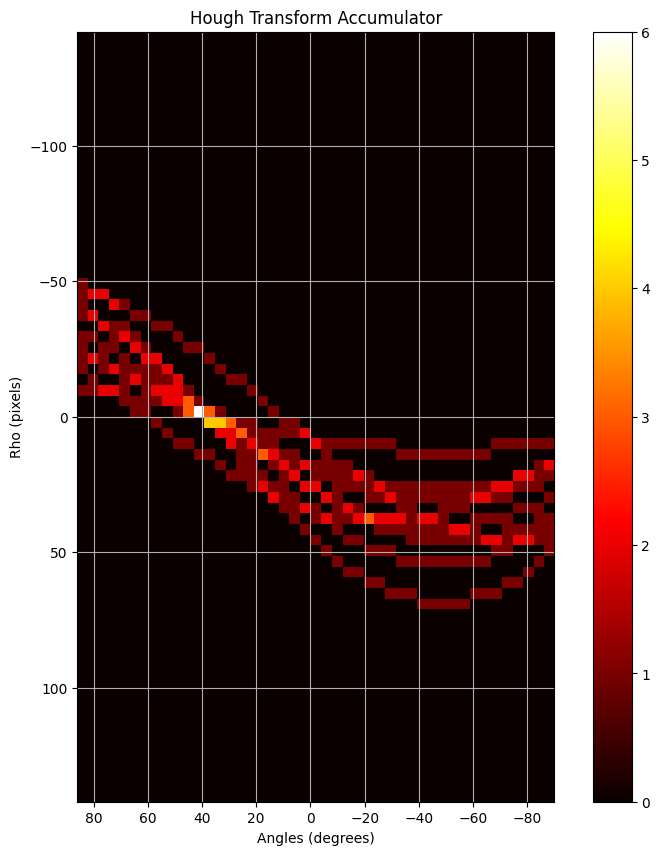

In [6]:
angle_step, rho_step = 4,4
accumulator, thetas, rhos = hough_line_points(x_points, y_points,angle_step, rho_step)
plot_hough_accumulator(accumulator, thetas, rhos)

## Comparing Different Levels of Discretization

We can compare the Hough Transform results with different levels of discretization:


In [7]:
# discretizations = [(0.2, 0.2), (0.5, 0.5), (0.8, 0.8), (1, 1), (1.5, 1.5)]

# for angle_step, rho_step in discretizations:
#     print(f"Angle Step: {angle_step} degrees, Rho Step: {rho_step} pixels")
#     accumulator, thetas, rhos = hough_line_points(x_points, y_points, angle_step, rho_step)
#     plot_hough_accumulator(accumulator, thetas, rhos)


## plotting with the lines

In [8]:
def get_hough_lines(accumulator, thetas, rhos, num_lines):
    lines = []
    accumulator_copy = accumulator.copy()  # Work on a copy to avoid modifying the original
    for _ in range(num_lines):
        idx = np.argmax(accumulator_copy)
        rho_idx, theta_idx = np.unravel_index(idx, accumulator_copy.shape)
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))
        # delete local maxima to be able to find next max
        accumulator_copy[rho_idx, theta_idx] = 0

    return lines


In [9]:
def plot_lines_on_points(x_points, y_points, lines, x_max, y_max):

    plt.figure(figsize=(6, 6))
    plt.scatter(x_points, y_points, color='blue', label='Points')
    for rho, theta in lines:
        if np.sin(theta) != 0:  # Avoid division by zero in case of vertical line
            x_vals = np.array([0, x_max])
            y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
            plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'rho={rho:.2f}, theta={np.rad2deg(theta):.1f}°')

    plt.title('Detected Lines and Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()


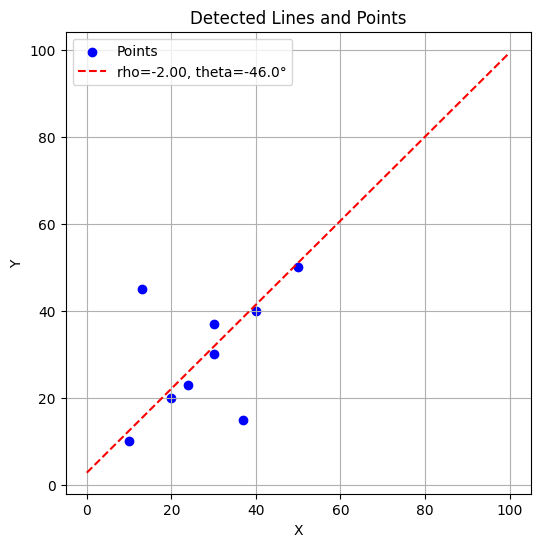

In [10]:
# Extract most prominent lines from the accumulator
num_lines = 1   # Number of lines to extract
lines = get_hough_lines(accumulator, thetas, rhos, num_lines)

plot_lines_on_points(x_points, y_points, lines, x_max=x_max, y_max=y_max)

## Great!!

## Now working on a real image

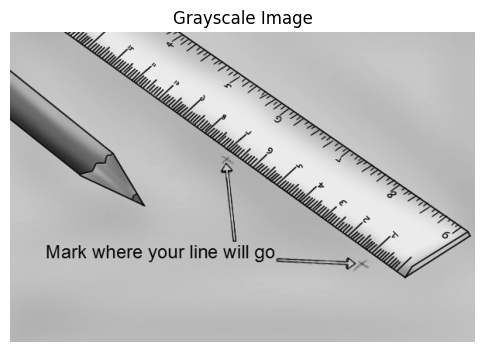

In [11]:
    from skimage import io, color
    import matplotlib.pyplot as plt
    import numpy as np

    image = io.imread('pics/ruler.bmp')

    # remove 4^th channel if needed, so it won't mess with the code
    if image.shape[-1] == 4:
        image = image[..., :3]

    # convert to grayscale
    gray_image = color.rgb2gray(image)

    plt.figure(figsize=(6, 6))
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()

## Creating an edge points using Canny algorithm

## Canny edge points algorithm!

## 1. Smoothing the image

In [12]:
# import numpy as np
import scipy.ndimage as ndi
def gaussian_filter(img, sigma):
    return ndi.gaussian_filter(img, sigma=sigma)
smoothed_image = gaussian_filter(gray_image, sigma=2.0)


## 2. Aplying the Sobel operator

In [13]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # the operator kernel
    
    Ix = ndi.convolve(img, Kx)
    Iy = ndi.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)        # Gradient magnitude
    theta = np.arctan2(Iy, Ix)  # Gradient direction
    
    return G, theta

gradient_magnitude, gradient_direction = sobel_filters(smoothed_image)


In [14]:
def non_max_suppression(G, theta):
    """
    Thin edges by suppressing non-maximum gradient values.
    """
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.float32)
    angle = theta * 180.0 / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            
            # Angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = G[i, j+1]
                r = G[i, j-1]
            # Angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = G[i+1, j-1]
                r = G[i-1, j+1]
            # Angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = G[i+1, j]
                r = G[i-1, j]
            # Angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = G[i-1, j-1]
                r = G[i+1, j+1]

            if G[i, j] >= q and G[i, j] >= r:
                Z[i, j] = G[i, j]
            else:
                Z[i, j] = 0

    return Z

# Apply non-maximum suppression
thinned_edges = non_max_suppression(gradient_magnitude, gradient_direction)


In [15]:
def threshold(img, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
    """
    Apply double threshold to classify strong, weak, and non-edges.
    """
    high_threshold = img.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    
    strong = 255
    weak = 50
    
    strong_i, strong_j = np.where(img >= high_threshold)
    weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

# Apply double thresholding
edges, weak, strong = threshold(thinned_edges)


In [16]:
def hysteresis(img, weak, strong=255):
    """
    Final step of Canny Edge Detection to track edges by hysteresis.
    """
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

# Perform edge tracking by hysteresis
edges = hysteresis(edges, weak, strong)


## Using Canny algorithm!

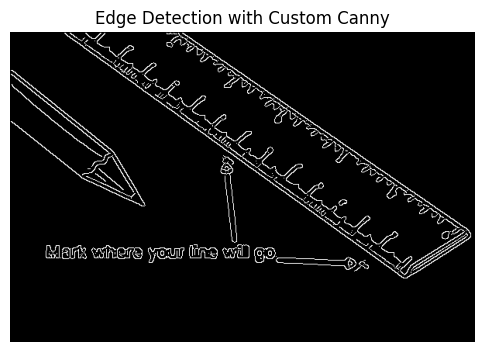

In [17]:
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection with Custom Canny')
plt.axis('off')
plt.show()


## Hough Transform on the edge points

## Show it all on the picture

In [19]:
def plot_lines_on_image(x_points, y_points, lines, x_max, y_max, image=None):
    plt.figure(figsize=(6, 6))
    if image is not None:
        plt.imshow(image, cmap='gray')  # Show the image in the background

    for rho, theta in lines:
        # Convert rho, theta representation back to cartesian representation
        if np.sin(theta) != 0:  # to not divide by zero
            x_vals = np.array([0, x_max])
            y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
            plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'rho={rho:.2f}, theta={np.rad2deg(theta):.1f}°')

    # plt.xlim(0, x_max)
    # plt.ylim(0, y_max)  # Flip the y-axis to match the image coordinates
    plt.title('Detected Lines and Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()


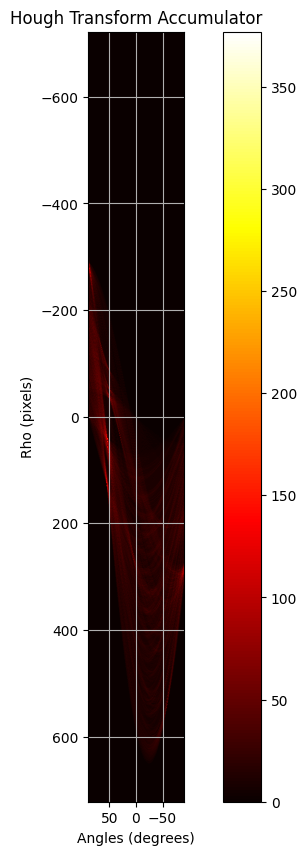

In [27]:
y_points, x_points = np.nonzero(edges)
angle_step, rho_step = 1, 1
accumulator, thetas, rhos = hough_line_points(x_points, y_points, angle_step, rho_step)
plot_hough_accumulator(accumulator, thetas, rhos)

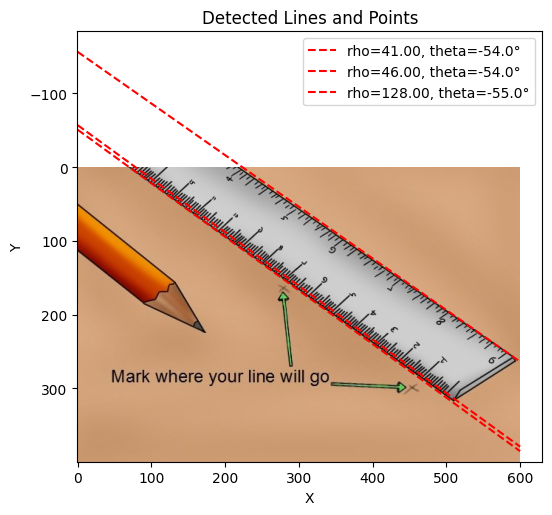

In [30]:
num_lines = 3  # Number of lines to show
lines = get_hough_lines(accumulator, thetas, rhos, num_lines)
x_max, y_max = gray_image.shape[1], gray_image.shape[0]
plot_lines_on_image(x_points, y_points, lines, x_max, y_max, image=image)